In [481]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import math
import zipfile
import os
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [482]:
seed = 42
torch.random.manual_seed(seed)

lr = 1e-2
epochs = 5000

root_path = "/home/stefan/Downloads"
EVALUATION = False

# Data preparation

In [483]:
def load_data(csv_path: str) -> Tuple[np.ndarray, np.ndarray]:
    ttheta = pd.read_csv(csv_path)
    t = np.array(ttheta["t"])
    theta = np.array(ttheta["theta"])
    return t, theta

In [484]:
def split_data(t: np.ndarray, theta: np.ndarray, threshold=1):
    # split data in two sections: before the force F is applied, and after
    theta_1, t_1 = [], []
    theta_2, t_2 = [], []
    force_flag = False

    t_1.append(t[0])
    theta_1.append(theta[0])
    for i in range(1, len(t)):
        if t[i] - t[i - 1] < threshold:  #
            if not force_flag:
                t_1.append(t[i])
                theta_1.append(theta[i])
            else:
                t_2.append(t[i])
                theta_2.append(theta[i])
        else:
            force_flag = True
            t_2.append(t[i])
            theta_2.append(theta[i])

    return np.array(t_1), np.array(theta_1), np.array(t_2), np.array(theta_2)

In [485]:
def get_next_zerotheta_timestamp(t, theta):
    # to find the next zero point.
    timestamp = 0
    for i in range(1, len(theta)):
        if theta[i - 1] * theta[i] < 0:
            timestamp = t[i]
            break
    return timestamp


def theta_func(thetaomega, t, alpha, beta):
    # function for solving differential equations.
    theta, omega = thetaomega
    a = -alpha * omega - beta * math.sin(theta)
    return np.array([omega, a])


def neg_theta_func(thetaomega, t, alpha, beta):
    return - theta_func(thetaomega, t, alpha, beta)

def derivative(t, theta):
    dthetadt = (theta[1:] - theta[:-1]) / (t[1:] - t[:-1])
    return dthetadt


def get_break_timestamp(
    break_t, theta_1_forward, theta_2_backward
):  
    # find the moment when F disappears by identifying the intersection point of the curves.
    min_val = math.inf
    min_idx = 0
    for i in range(len(break_t) - 1):
        val = abs(theta_1_forward[i] - theta_2_backward[i])
        dtheta_1 = theta_1_forward[i + 1] - theta_1_forward[i]
        dtheta_2 = theta_2_backward[i + 1] - theta_2_backward[i]
        val += abs((dtheta_1 - dtheta_2) / (break_t[i + 1] - break_t[i]))
        if val < min_val:
            min_val = val
            min_idx = i

    return break_t[min_idx]


def plot1d_full_data(
    t_1, theta_1, t_2, theta_2, break_t, theta_break, break_timestamp
):
    # used for debugging, plot the whole motion
    fig = plt.figure(figsize=(16, 4))

    ax = fig.add_subplot()
    ax.plot(t_1, theta_1, lw=1, color="blue")
    ax.plot(t_2, theta_2, lw=1, color="blue")
    ax.plot(break_t, theta_break, lw=1, color="red")
    # ax.scatter(
    #     [break_timestamp], [theta_break[break_t == break_timestamp]], s=20, color="red"
    # )

    plt.show()
    plt.cla()
    plt.close("all")

In [486]:
def reconstruct_missing_segment(t_1, theta_1, t_2, theta_2, alpha, beta):
    # initial conditions
    theta0 = theta_1[-1]
    omega0 = (theta_1[-1] - theta_1[-2]) / (t_1[-1] - t_1[-2])
    thetaomega0 = [theta0, omega0]

    break_t = np.linspace(t_1[-1], t_2[0], 200)
    thetaomega_sol = odeint(theta_func, thetaomega0, break_t, args=(alpha, beta))
    theta_break = thetaomega_sol[:, 0]

    # find return to zero
    break_timestamp = get_next_zerotheta_timestamp(break_t, theta_break)

    return break_t, theta_break, break_timestamp

# Model

The theoretical basis for the model is the acceleration formula: 

$$\frac{\mathrm{d}^2 \theta}{\mathrm{d} t^2} = - \alpha \frac{\mathrm{d} \theta}{\mathrm{d} t} - \beta \sin \theta(t)$$

where $\alpha = \frac{\mu}{m}$ and $\beta = \frac{g}{l}$. After $t_{F put}$, an external force is applied and the $\beta$ parameter becomes $\frac{g}{l} + \frac{F}{m l}$.

The model has to approximate the length $l$, the air resistance $\mu$, the magnitude of the external force $F$. We know that $m=1$ and $g=9.8$.

In [487]:
class SinglePendulum(nn.Module):
    def __init__(self):
        super().__init__()

        self.alpha = nn.Parameter(torch.randn((1,), requires_grad=True))
        self.beta_1 = nn.Parameter(torch.randn((1,), requires_grad=True))
        self.beta_2 = nn.Parameter(torch.randn((1,), requires_grad=True))

    def get_alphabeta(self, add_force=False):
        alpha = self.alpha
        beta = 0

        if add_force:
            beta = self.beta_1
        else:
            beta = self.beta_2

        return alpha, beta

    def forward(self, theta, omega, add_force=False):
        if not add_force:
            a = - self.alpha * omega - self.beta_1 * torch.sin(theta)
        else:
            a = - self.alpha * omega - self.beta_2 * torch.sin(theta)
        return a

In [488]:
torch.set_default_dtype(torch.float64)
pendulum = SinglePendulum().double()

# takes in theta(t) and omega(t)=theta'(t)
pendulum(torch.tensor(0.1), torch.tensor(0.2))

tensor([-0.0802], grad_fn=<SubBackward0>)

# Training

In [489]:
def build_dataset(csv_path):
    dataset_before_F, dataset_after_F = {}, {}

    t, theta = load_data(csv_path)
    t1, theta1, t2, theta2 = split_data(t, theta, threshold = 1)
    omega1 = derivative(t1, theta1)
    omega2 = derivative(t2, theta2)

    # labels
    a1 = torch.from_numpy(derivative(t1[:-1], omega1))
    a2 = torch.from_numpy(derivative(t2[:-1], omega2))

    # inputs
    _omega1, _omega2 = torch.from_numpy(omega1[:-1]), torch.from_numpy(omega2[:-1])
    _theta1, _theta2 = torch.from_numpy(theta1[:-2]), torch.from_numpy(theta2[:-2])
    
    dataset_before_F["acc"] = a1
    dataset_before_F["inputs"] = _theta1, _omega1

    dataset_after_F["acc"] = a2
    dataset_after_F["inputs"] = _theta2, _omega2
    
    return dataset_before_F, dataset_after_F

In [490]:
def train(model, dataset_before_F, dataset_after_F, epochs, lr):
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min',
                              factor=0.1, patience=500, min_lr=1e-6)

    lrs, losses = [], []

    for epoch in range(epochs):
        # forward pass
        theta, omega = dataset_before_F["inputs"]
        pred_acc = model(theta, omega, add_force=False).squeeze()
        loss = F.mse_loss(dataset_before_F["acc"], pred_acc)

        theta, omega = dataset_after_F["inputs"]
        pred_acc = model(theta, omega, add_force=True).squeeze()
        loss += F.mse_loss(dataset_after_F["acc"], pred_acc)

        # backkward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(loss)

        # stats
        lrs.append(optimizer.param_groups[0]["lr"])
        losses.append(loss.item())

        if (epoch + 1) % 2500 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.7f}")
        
    return lrs, losses

Epoch 2500, Loss: 0.0004526
Epoch 5000, Loss: 0.0004506


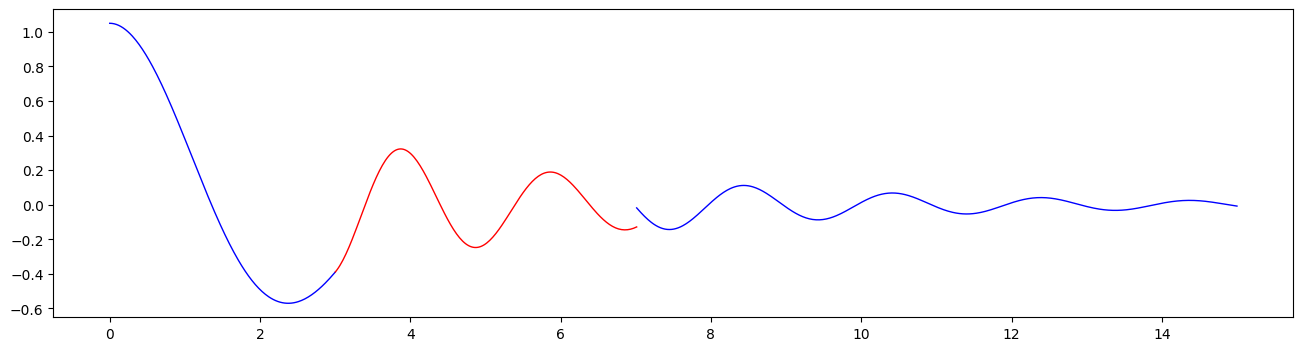

In [491]:
if not EVALUATION:
    dataset_before_F, dataset_after_F = build_dataset(f"{root_path}/pendulum_train.csv")
    lrs, losses = train(pendulum, dataset_before_F, dataset_after_F, epochs, lr)

    # visualization for debug
    t, theta = load_data(f"{root_path}/pendulum_train.csv")
    t_1, theta_1, t_2, theta_2 = split_data(t, theta)
    alpha, beta = pendulum.get_alphabeta(add_force=False)
    alpha, beta = alpha.item(), beta.item()

    break_t, theta_break, break_timestamp = reconstruct_missing_segment(
        t_1, theta_1, t_2, theta_2, alpha, beta
    )

    plot1d_full_data(t_1, theta_1, t_2, theta_2, break_t, theta_break, break_timestamp)

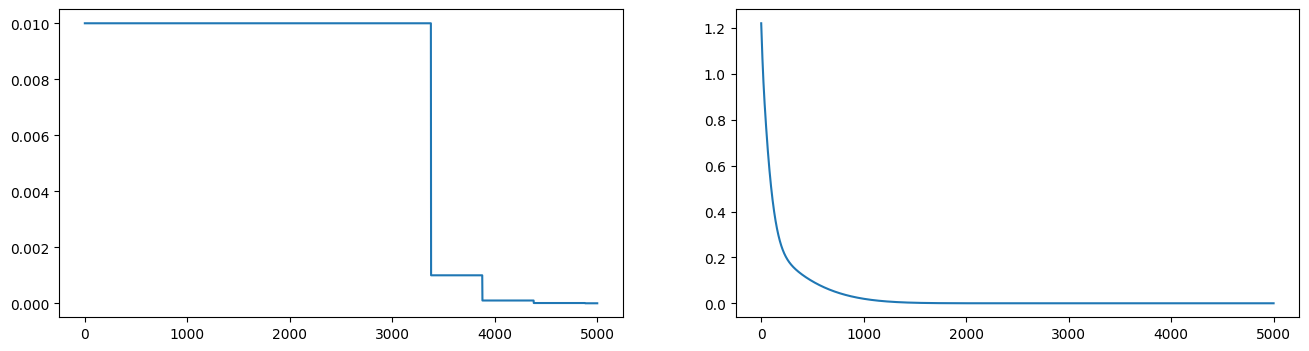

In [492]:
if not EVALUATION:
    f, axarr = plt.subplots(1,2, figsize=(16, 4))
    axarr[0].plot(lrs)
    axarr[1].plot(losses)

# Submission

In [493]:
if not EVALUATION:
    1/0

ZeroDivisionError: division by zero

In [ ]:
def estimate_and_save_parameters(csv_path: str, submission_path: str):
    # 1. get data
    dataset_before_F, dataset_after_F = build_dataset(csv_path)

    t, theta = load_data(csv_path)
    t_1, theta_1, t_2, theta_2 = split_data(t, theta)
    omega_1 = derivative(t_1, theta_1)
    omega_2 = derivative(t_2, theta_2)
    
    # 2. train model 
    model = SinglePendulum()
    train(model, dataset_before_F, dataset_after_F, 20000, 1e-3)

    alpha = (model.alpha).detach().item()
    beta_1 = (model.beta_1).detach().item()
    beta_2 = (model.beta_2).detach().item()
    
    # 3. extract parameters
    l = 9.81/beta_1
    mu = alpha
    Force = (beta_2 - beta_1) * l

    # 4. estimate other parameters
    sample_freq = 1000
    t = np.linspace(t_2[-1], t_2[-1]+3, int(sample_freq*3)+1)
    pred_theta = odeint(theta_func, [theta_2[-1], omega_2[-1]], t-3, args=(alpha, beta_2))[:, 0]
    get_next_zerotheta_timestamp(t, pred_theta)

    break_t = np.linspace(t_1[-1], t_2[0], int(sample_freq * (t_2[0] - t_1[-1])) + 1)
    theta1_fd = odeint(theta_func, [theta_1[-1], omega_1[-1]], break_t, args=(alpha, beta_1))[:, 0]
    theta2_bd = odeint(neg_theta_func, [theta_2[0], omega_2[0]], break_t, args=(alpha, beta_2))[::-1, 0]
    break_timestamp = get_break_timestamp(break_t, theta1_fd, theta2_bd)

    t_nextzerotheta = get_next_zerotheta_timestamp(t, pred_theta)
    t_Fput = break_timestamp

    # 4. submission
    pd.DataFrame([{
        "l": l,
        "miu": mu,
        "F": Force,
        "t_nextzerotheta": t_nextzerotheta,
        "t_Fput": t_Fput,
    }]).to_csv(submission_path, index=False)

In [ ]:
TRAIN_PATH = "/bohr/train-08bw/v1/" if EVALUATION else f"{root_path}/"
estimate_and_save_parameters(
    csv_path=TRAIN_PATH + "pendulum_train.csv", submission_path="submission_train.csv"
)  # Solve the training set equation.

Epoch 2500, Loss: 0.0004506
Epoch 5000, Loss: 0.0004506


In [ ]:
# Load the test set
# “DATA_PATH” is an environment variable for the encrypted test set.
# After submission, the test set can be accessed for system scoring in the following manner, but the participants cannot download it directly.
if os.environ.get("DATA_PATH"):
    DATA_PATH = os.environ.get("DATA_PATH") + "/"

    estimate_and_save_parameters(
        csv_path=DATA_PATH + "pendulum_testA.csv", submission_path="submissionA.csv"
    )  # Solve the equation for the Public test set （test set A）.
    estimate_and_save_parameters(
        csv_path=DATA_PATH + "pendulum_testB.csv", submission_path="submissionB.csv"
    )  # Solve the equation for the Private test set （test set B）.

    # Define the files to be packaged and the compressed file name.
    files_to_zip = ["submissionA.csv", "submissionB.csv"]
    zip_filename = "submission.zip"

    # Create a zip file.
    with zipfile.ZipFile(zip_filename, "w") as zipf:
        for file in files_to_zip:
            # Add files to the zip file.
            zipf.write(file, os.path.basename(file))

    print(f"{zip_filename} is created successfully!")
else:
    print(
        "When the baseline is running, this error message will appear because the test set cannot be read, which is a normal phenomenon."
    )

When the baseline is running, this error message will appear because the test set cannot be read, which is a normal phenomenon.
